In [1]:
%matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns



import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf

import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)
from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
# locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

# from datetime import date
import datetime


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

saveFigures is set to: True
Done loading packages


# Since week 46, case-counts have been available, distributed by both age and vaccinestatus
 As most infections has also occured since then, it should be possible to estimate *exactly* how many have various degrees of immunity

# Get data

In [2]:
# Define paths
rootdir_data = os.getcwd() +"\\..\\DanskeData\\" 

path_data = rootdir_data + "ssi_data\\"
path_dash = rootdir_data + "ssi_dashboard\\"
path_vacc = rootdir_data + "ssi_vacc\\"

path_figs = os.getcwd() +"\\..\\Figures\\" 

In [3]:
# Data is (only) in the file from the most recent tuesday. 
# Should be made smarter, but here hardcoded
# tuePath = 'SSI_data_2022-01-25'
# Now automatic finding of latest tuesday:
for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        tuePath = 'SSI_data_'+str(dayToCheck)

print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '\\'

df1 = pd.read_csv(dirPath+'gennembrudsinfektioner_table1.csv',delimiter=';')

df2_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
df2_H = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_indlagte.csv',delimiter=';')
df2_D = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_dode.csv',delimiter=';')
df2_R = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_repositive.csv',delimiter=';')
df2_Int = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_intensiv.csv',delimiter=';')
df2_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_tests.csv',delimiter=';')

df3 = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv',delimiter=';',decimal=",")
df3_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv',delimiter=';',decimal=",")
df3_H = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_indlagte.csv',delimiter=';',decimal=",")
df3_D = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_dode.csv',delimiter=';',decimal=",")
df3_Int = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_intensiv.csv',delimiter=';',decimal=",")
df3_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_tests.csv',delimiter=';',decimal=",")

Path to latest Tuesday was SSI_data_2022-03-08


In [4]:

weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

curOrder = np.argsort(weekDTs)
weekDTs = np.array(weekDTs)
weekDTs = weekDTs[curOrder]
        
sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'

allStatus = [sNone,sOne,sTwo,sFull,sReva]


ageGroups = df2_C.Aldersgruppe.values
# print(ageGroups)
# weekNames = df1.Ugenummer
weekNames = df1.Ugenummer.values[curOrder]
weekNamesShort = [x[4:6] for x in weekNames]
wInt = [int(x[4:6]) for x in weekNames]
wIntRange = np.arange(len(wInt))

allDates = np.array(weekDTs)[curOrder]
print(weekNames)

# Make function for gettings particular parts
def getTimeSeriesSingle(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    
    agedf = thisdf[thisdf.Aldersgruppe==curAge]
    allVals = []
    for curWeek in weekNames:
        toAdd = agedf[curWeek+'_'+curStatus].values[0]
        allVals.append(toAdd)
    allVals = np.array(allVals)

    return allVals


def getTimeSeries(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    # If curAge is just a string, return the given array
    if (type(curAge)==str):
        agedf = thisdf[thisdf.Aldersgruppe==curAge]
        allVals = []
        for curWeek in weekNames:
            toAdd = agedf[curWeek+'_'+curStatus].values[0]
            allVals.append(toAdd)
        allVals = np.array(allVals)
        
        return allVals 
        
    else:
        # If curAge is not a string, it is assumed to be a list of strings
        totCount = []
        for thisAge in curAge:
            agedf = thisdf[thisdf.Aldersgruppe==thisAge]
            allVals = []
            for curWeek in weekNames:
                toAdd = agedf[curWeek+'_'+curStatus].values[0]
                allVals.append(toAdd)
            allVals = np.array(allVals)
            if len(totCount) == 0:
                totCount = allVals 
            else:
                totCount = totCount + allVals
        return totCount

def getTimeSeriesAll(thisdf=df2_C,curAge='Alle',weekNames=weekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)

['Uge 46-2021' 'Uge 47-2021' 'Uge 48-2021' 'Uge 49-2021' 'Uge 50-2021'
 'Uge 51-2021' 'Uge 52-2021' 'Uge 01-2022' 'Uge 02-2022' 'Uge 03-2022'
 'Uge 04-2022' 'Uge 05-2022' 'Uge 06-2022' 'Uge 07-2022' 'Uge 08-2022'
 'Uge 09-2022']


In [5]:
def estimatePopCountArray(curStatus,curAge):
    if (type(curAge)==str):
        curCase = getTimeSeries(df2_T,curStatus=curStatus,curAge=curAge)
        curInci = getTimeSeries(df3_T,curStatus=curStatus,curAge=curAge)

        curPopCount = 100000*curCase/curInci

        curPopCount[curCase == 0] = 0
        
        return curPopCount
    else:
        
        DoneWithFirst = False
        for thisAge in curAge:
            curCase = getTimeSeries(df2_T,curStatus=curStatus,curAge=thisAge)
            curInci = getTimeSeries(df3_T,curStatus=curStatus,curAge=thisAge)

            curPopCount = 100000*curCase/curInci
            # avgPopCount = np.mean(curPopCount[-4:])
            
            if (DoneWithFirst == False):
                totPopCount = curPopCount 
                DoneWithFirst = True
            else:            
                totPopCount = totPopCount + curPopCount 
        return totPopCount
        
def estimatePopCount(curStatus,curAge,firstIndex=-4):
    return np.mean(estimatePopCountArray(curStatus,curAge)[firstIndex:])

estimatePopCount(sReva,'12-15')        
# # estimatePopCount(sTwo,'80+')
# # estimatePopCount(sNone,['50-59','60-64','65-69'])
# # getTimeSeries(df3_D,curStatus=sNone,curAge=['50-59','60-64','65-69'])[-4:].sum()
# print(estimatePopCountArray(sNone,['50-59','60-64','65-69']))
# print(np.mean(estimatePopCountArray(sNone,['50-59','60-64','65-69'])[-4:]))
# estimatePopCount(sNone,['50-59','60-64','65-69'])

685.7493126156826

# Start by just plotting vaccinestatus

# Make an 80+ test

In [6]:
ageGroups
# getTimeSeries(df2_C,sReva,'0-5')

array(['0-5', '6-11', '12-15', '16-19', '20-29', '30-39', '40-49',
       '50-59', '60-64', '65-69', '70-79', '80+', '12+', 'Alle'],
      dtype=object)

In [7]:
counts = [] 
for curS in allStatus:
    # counts.append(estimatePopCountArray(curS,'80+'))
    # toAdd = estimatePopCountArray(curS,'12-15')
    toAdd = estimatePopCountArray(curS,'20-29')
    counts.append(toAdd)

In [8]:
# dfPopNone = pd.DataFrame()

# for age in ageGroups:
#     dfPopNone[age] = estimatePopCountArray(sReva,age)
# display(dfPopNone)
# df1
# # count = getTimeSeries(df2_H,sNone,'20-29')
# # inci = getTimeSeries(df3_H,sNone,'20-29')
# # rat = count/inci

# # print(rat[-1] * getTimeSeries(df3_C,sNone,'20-29'))
# # getTimeSeries(df2_C,sNone,'20-29')




In [9]:
# df1.iloc[:,1:4].sum(axis=1)
# estimatePopCountArray(sFull,'20-29')
# counts[4]
# plt.figure()
# # plt.plot(allDates,counts[4])
# plt.plot(weekDTs,counts[4])

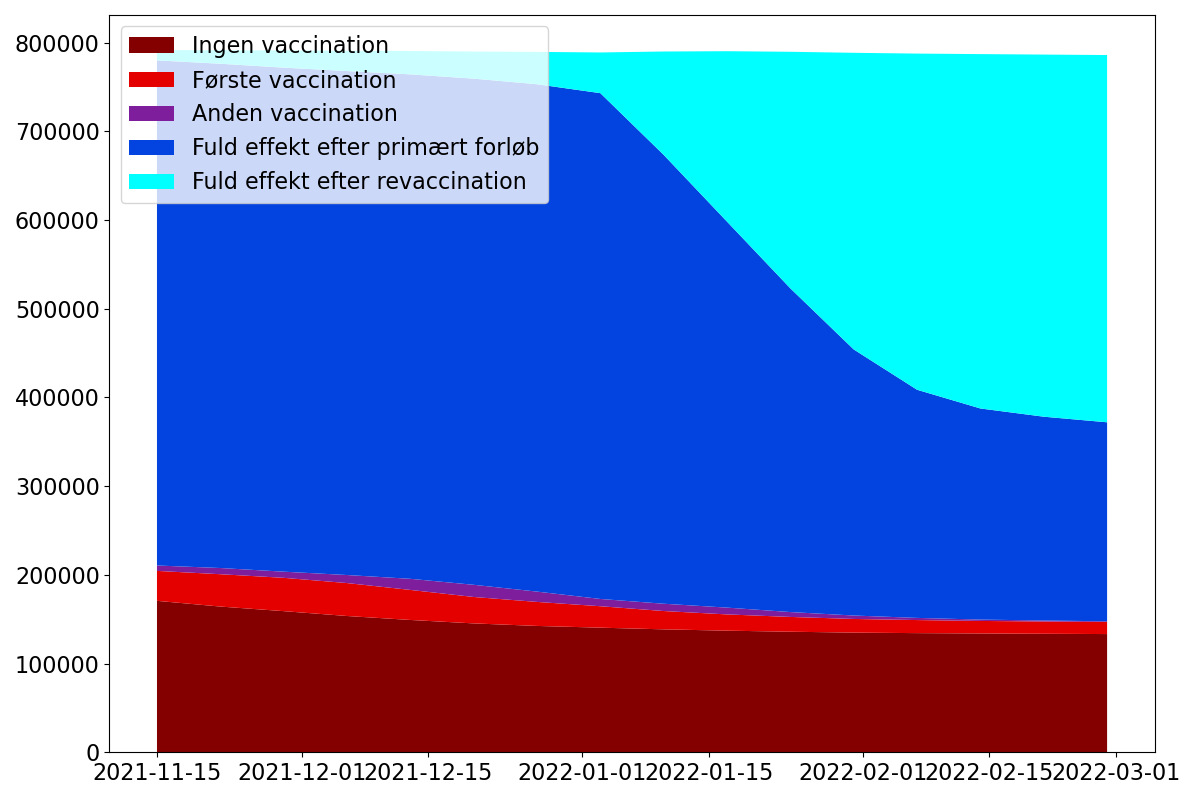

In [10]:
fig,ax1 = plt.subplots()

# ax1.fill_between(allDates,counts[0])
# ax1.fill_between(allDates,counts[0]+counts[1],counts[0])
# ax1.fill_between(allDates,counts[0]+counts[1]+counts[2],counts[0]+counts[1])
# ax1.fill_between(allDates,counts[0]+counts[1]+counts[4],counts[0]+counts[1])
# ax1.fill_between(allDates,counts[0]+counts[1]+counts[3]+counts[4],counts[0]+counts[1]+counts[4])

allColors = ['xkcd:dark red','xkcd:red','xkcd:purple','xkcd:blue','xkcd:cyan']

onlySecond = counts[2] -  (counts[3] + counts[4]) 

ax1.stackplot(weekDTs,
    counts[0],
    counts[1],
    onlySecond,
    counts[3],
    counts[4],
    colors=allColors,
    labels=allStatus
)

# ax1.legend(bbox_to_anchor=(1.05,0.5),loc='center left')
ax1.legend(loc='upper left')
fig.tight_layout()

# ax1.plot(weekDTs,counts[0],'k')
# ax1.plot(weekDTs,counts[0]+counts[1],'k')
# ax1.plot(weekDTs,counts[0]+counts[1]+onlySecond,'k')

# ax1.stackplot(allDates,counts[0],counts[1],counts[2])

In [11]:
ageGroups

array(['0-5', '6-11', '12-15', '16-19', '20-29', '30-39', '40-49',
       '50-59', '60-64', '65-69', '70-79', '80+', '12+', 'Alle'],
      dtype=object)

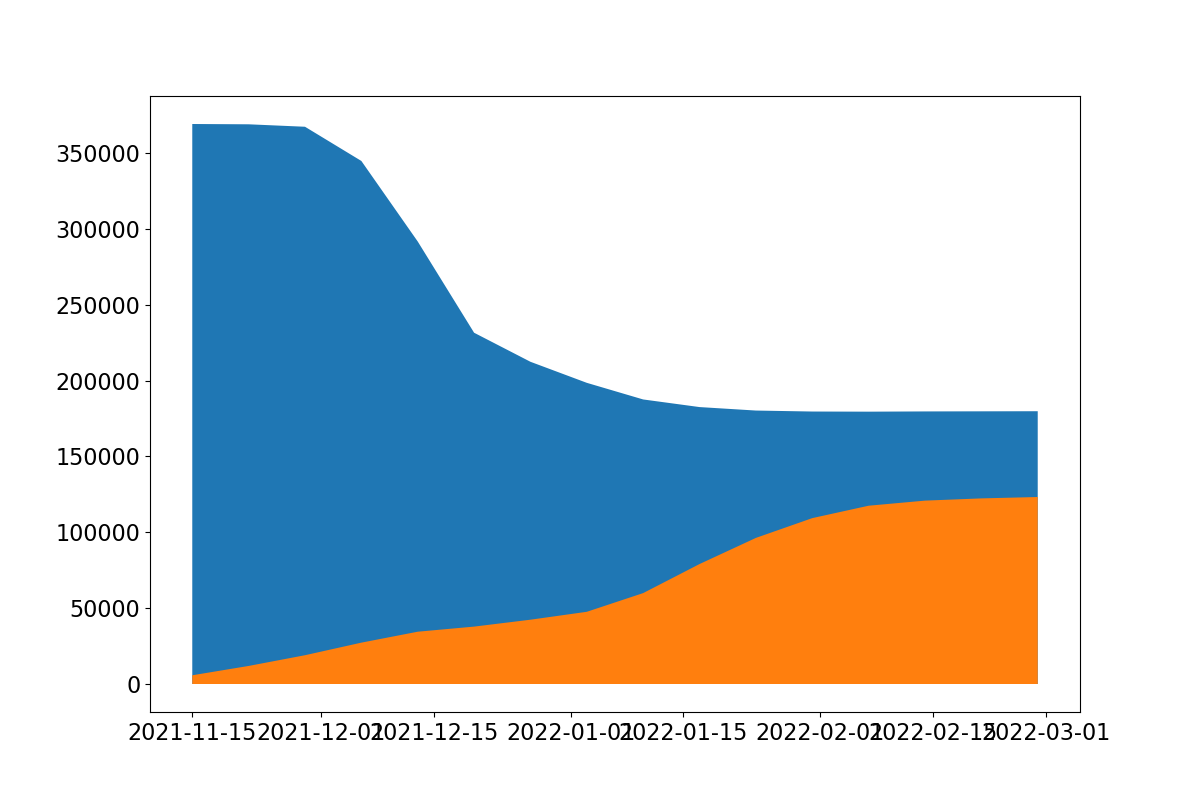

In [12]:
curCase = getTimeSeries(df2_C,sNone,'6-11') 
curPop = estimatePopCountArray(sNone,'6-11')

fig,ax1 = plt.subplots()
ax1.fill_between(weekDTs,curPop)
ax1.fill_between(weekDTs,np.cumsum(curCase))

In [13]:
# def estimatePopCountArray(curStatus,curAge):
#     if (type(curAge)==str):
#         curCase = getTimeSeries(df2_C,curStatus=curStatus,curAge=curAge)
#         curInci = getTimeSeries(df3_C,curStatus=curStatus,curAge=curAge)

#         curPopCount = 100000*curCase/curInci
        
#         return curPopCount
#     else:
        
#         DoneWithFirst = False
#         for thisAge in curAge:
#             curCase = getTimeSeries(df2_C,curStatus=curStatus,curAge=thisAge)
#             curInci = getTimeSeries(df3_C,curStatus=curStatus,curAge=thisAge)

#             curPopCount = 100000*curCase/curInci
#             # avgPopCount = np.mean(curPopCount[-4:])
            
#             if (DoneWithFirst == False):
#                 totPopCount = curPopCount 
#                 DoneWithFirst = True
#             else:            
#                 totPopCount = totPopCount + curPopCount 
#         return totPopCount
        
# def estimatePopCount(curStatus,curAge,firstIndex=-4):
#     return np.mean(estimatePopCountArray(curStatus,curAge)[firstIndex:])
        
# # estimatePopCount(sTwo,'80+')
# estimatePopCountArray(sNone,'80+')
# # estimatePopCount(sNone,['50-59','60-64','65-69'])
# # getTimeSeries(df3_D,curStatus=sNone,curAge=['50-59','60-64','65-69'])[-4:].sum()
# # print(estimatePopCountArray(sNone,['50-59','60-64','65-69']))
# # print(np.mean(estimatePopCountArray(sNone,['50-59','60-64','65-69'])[-4:]))
# # estimatePopCount(sNone,['50-59','60-64','65-69'])